In [23]:
import numpy as np
import pandas as pd
import os
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

print("✅ Libraries loaded successfully.")


✅ Libraries loaded successfully.


In [25]:
# === CONFIGURATION ===
LOOK_BACK = 24
TARGET_COL = 0  # Index of the target column
EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 10

DATA_DIR = r"C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab"
MODEL_PATH = os.path.join(DATA_DIR, "lstm_model.h5")
CHECKPOINT_PATH = os.path.join(DATA_DIR, "E1-cp-best.h5")

print("✅ Configuration set.")


✅ Configuration set.


In [27]:
# === DATA LOADING ===
def load_dataset(path):
    return pd.read_csv(path)

train_df = load_dataset(os.path.join(DATA_DIR, "train_data.csv"))
val_df   = load_dataset(os.path.join(DATA_DIR, "val_data.csv"))
test_df  = load_dataset(os.path.join(DATA_DIR, "test_data.csv"))

print("✅ Data loaded successfully.")
train_df.head()


✅ Data loaded successfully.


,daylight_savings_status,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,...,hour_cos,month_sin,month_cos,day_type_1,day_type_2,day_type_3,day_type_4,day_type_5,day_type_6,day_type_7
0,0.0,1.494038,0.0,0.0,0.0,-0.684403,0.891128,0.690366,-0.712568,-0.679431,...,1.414214,-0.700959,-1.218894,-0.411966,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,2.452266
1,0.0,0.436419,0.0,0.0,0.0,-0.684403,0.919287,0.364091,-0.712568,-0.679431,...,1.366025,-1.219679,-0.702314,2.427388,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,-0.407786
2,0.0,0.088116,0.0,0.0,0.0,-0.684403,0.806648,0.298836,-0.712568,-0.679431,...,1.224745,-1.219679,-0.702314,2.427388,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,-0.407786
3,0.0,-0.633310,0.0,0.0,0.0,-0.684403,0.694009,0.298836,-0.712568,-0.679431,...,1.000000,-1.219679,-0.702314,2.427388,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,-0.407786
4,0.0,-0.633806,0.0,0.0,0.0,-0.684403,0.581369,0.298836,-0.712568,-0.679431,...,0.707107,-1.219679,-0.702314,2.427388,-0.407596,-0.407596,-0.407596,-0.407596,-0.407596,-0.407786


In [29]:
# === SEQUENCE CREATION ===
def create_sequences(df, look_back, target_idx):
    X, y = [], []
    data = df.values
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_df, LOOK_BACK, TARGET_COL)
X_val, y_val     = create_sequences(val_df, LOOK_BACK, TARGET_COL)
X_test, y_test   = create_sequences(test_df, LOOK_BACK, TARGET_COL)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (6108, 24, 39), (6108,)
Validation shape: (1728, 24, 39), (1728,)
Test shape: (852, 24, 39), (852,)


In [31]:
# === MODEL BUILDING ===
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(LOOK_BACK, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

print("✅ Model compiled.")
model.summary()


✅ Model compiled.


C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          26,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,737 (112.25 KB)

 Trainable params: 28,737 (112.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# === CALLBACKS ===
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("✅ Callbacks initialized.")


✅ Callbacks initialized.


In [35]:
# === TRAINING ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
)

print("✅ Training complete.")


Epoch 1/10
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166
Epoch 1: val_loss improved from inf to 0.00481, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0165 - val_loss: 0.0048
Epoch 2/10
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 2: val_loss improved from 0.00481 to 0.00385, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 3/10
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6252e-04
Epoch 3: val_loss improved from 0.00385 to 0.00334, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.6201e-04 - val_loss: 0.0033
Epoch 4/10
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8241e-04
Epoch 4: val_loss improved from 0.00334 to 0.00316, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8207e-04 - val_loss: 0.0032
Epoch 5/10
184/191 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7088e-04
Epoch 5: val_loss improved from 0.00316 to 0.00287, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7078e-04 - val_loss: 0.0029
Epoch 6/10
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2418e-04
Epoch 6: val_loss improved from 0.00287 to 0.00261, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.2419e-04 - val_loss: 0.0026
Epoch 7/10
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7611e-04
Epoch 7: val_loss improved from 0.00261 to 0.00233, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7614e-04 - val_loss: 0.0023
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3798e-04
Epoch 8: val_loss did not improve from 0.00233
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.3802e-04 - val_loss: 0.0023
Epoch 9/10
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2935e-04
Epoch 9: val_loss improved from 0.00233 to 0.00209, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2946e-04 - val_loss: 0.0021
Epoch 10/10
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1862e-04
Epoch 10: val_loss improved from 0.00209 to 0.00190, saving model to C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1906e-04 - val_loss: 0.0019
✅ Training complete.


In [37]:
# === EVALUATION ===
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

val_rmse = np.sqrt(val_loss)
test_rmse = np.sqrt(test_loss)

print(f"\n✅ Validation RMSE: {val_rmse:.4f}")
print(f"✅ Test RMSE: {test_rmse:.4f}")



✅ Validation RMSE: 0.0435
✅ Test RMSE: 0.0350


In [41]:
# === SAVE FINAL MODEL ===
model.save(MODEL_PATH)
print(f"\n✅ Model saved to: {MODEL_PATH}")
print(f"✅ Best checkpoint saved to: {CHECKPOINT_PATH}")



✅ Model saved to: C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\lstm_model.h5
✅ Best checkpoint saved to: C:\Users\PMLS\ml\Machine Learning\Machine Learning lab\Open ended lab\E1-cp-best.h5


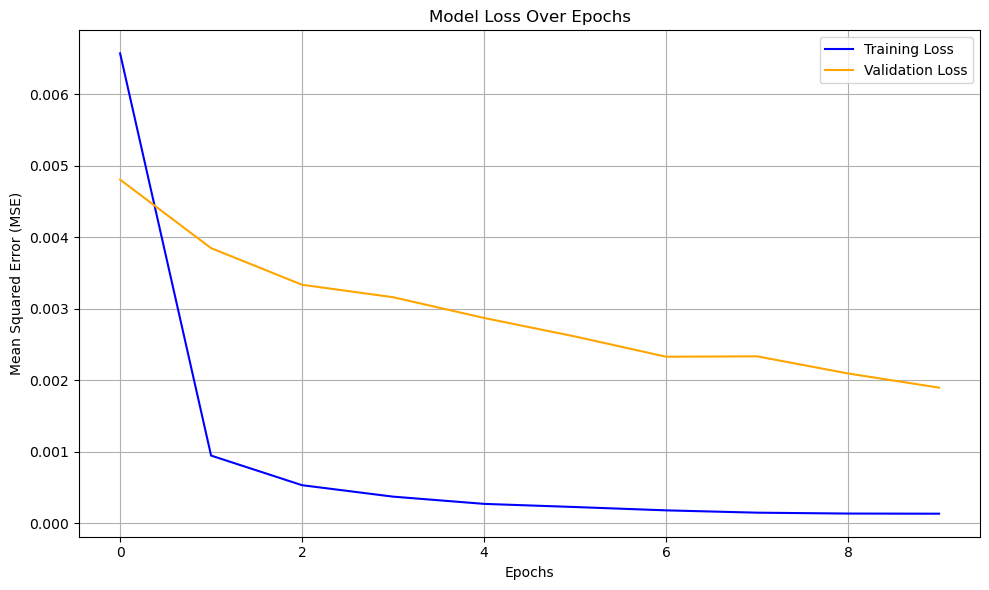

In [43]:
import matplotlib.pyplot as plt

# === PLOT TRAINING AND VALIDATION LOSS ===
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
